In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from presnet import PResNet
from hybrid_encoder import HybridEncoder
from rtdetrv2_decoder import RTDETRTransformerv2
from rtdetr_postprocessor import RTDETRPostProcessor
from rtdetrv2_criterion import RTDETRCriterionv2
from matcher import HungarianMatcher
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
# Setup Feature Extractor
presnet = PResNet(depth= 34,
                  variant = 'd',
                  freeze_at = -1,
                  return_idx = [1, 2, 3],
                  num_stages = 4,
                  freeze_norm = False,
                  pretrained = True )
    

Load PResNet34 state_dict


In [3]:
encoder = HybridEncoder(  in_channels = [128, 256, 512],
                          feat_strides = [8, 16, 32],
                          # intra
                          hidden_dim = 256,
                          use_encoder_idx = [2],
                          num_encoder_layers = 1,
                          nhead = 8,
                          dim_feedforward = 1024,
                          dropout = 0.,
                          enc_act = 'gelu' ,
                          # cross
                          expansion = 0.5,
                          depth_mult = 1,
                          act = 'silu')

In [4]:
decoder = RTDETRTransformerv2(feat_channels = [256, 256, 256],
                              feat_strides = [8, 16, 32],
                              hidden_dim = 256,
                              num_levels = 3,
                              num_layers = 4,
                              num_queries = 300,
                              num_denoising = 100,
                              label_noise_ratio = 0.5,
                              box_noise_scale = 1.0, # 1.0 0.4
                              eval_idx = 2,
                              # NEW
                              num_points = [4, 4, 4], # [3,3,3] [2,2,2]
                              cross_attn_method = 'default', # default, discrete
                              query_select_method = 'default' # default, agnostic 
                              )

In [5]:
postprocessor = RTDETRPostProcessor()

In [6]:
losses = ['vfl', 'boxes']
weight_dict={'cost_class': 2, 'cost_bbox':5, 'cost_giou':2}
matcher = HungarianMatcher(use_focal_loss=False, weight_dict = weight_dict)
weight_dict = {'loss_vfl': 1, 'loss_bbox': 5, 'loss_giou': 2}
criterion = RTDETRCriterionv2(losses=losses, weight_dict=weight_dict, matcher=matcher)

In [7]:
class Model(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
        self.backbone = presnet
        self.encoder = encoder
        self.decoder = decoder
        self.postprocessor = postprocessor
        
    def forward(self, images, targets = None):
        features = self.backbone(images)
        features = self.encoder(features)
        out = self.decoder(features, targets)
        return out


In [8]:
img_cv = cv2.imread("people.jpeg")
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

h, w = img_cv.shape[0:2]
orig_size = torch.tensor([w, h])[None]


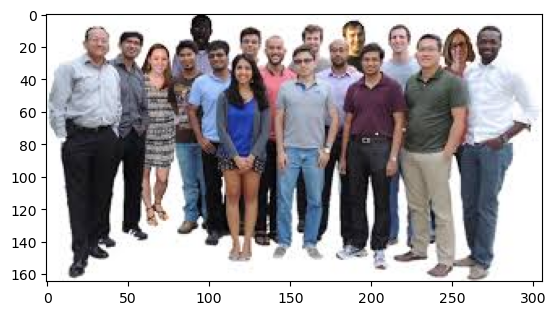

In [9]:
plt.imshow(img_cv)
plt.show()

In [10]:
detr = Model()


In [17]:
transforms = T.Compose([T.ToPILImage(),T.Resize((128, 128)), T.ToTensor()])

img = transforms(img_cv).unsqueeze(0)

In [18]:
# Training Loop
detr.eval()
detr.cuda()

Model(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): ModuleList(
          (0): BasicBlock(
            (short): ConvNormLayer(
      

In [19]:
out = detr(img.cuda(), orig_size.cuda())
print(out.keys())

out: 0 torch.Size([1, 128, 16, 16])
out: 1 torch.Size([1, 256, 8, 8])
out: 2 torch.Size([1, 512, 4, 4])
out: 0 torch.Size([1, 256, 16, 16])
out: 1 torch.Size([1, 256, 8, 8])
out: 2 torch.Size([1, 256, 4, 4])
dict_keys(['pred_logits', 'pred_boxes'])


In [20]:
test_template = torch.randn(1, 3, 128, 128).cuda()

In [21]:
feats = presnet(test_template)

out: 0 torch.Size([1, 128, 16, 16])
out: 1 torch.Size([1, 256, 8, 8])
out: 2 torch.Size([1, 512, 4, 4])


In [22]:
feats = presnet(img.cuda())

out: 0 torch.Size([1, 128, 16, 16])
out: 1 torch.Size([1, 256, 8, 8])
out: 2 torch.Size([1, 512, 4, 4])


In [51]:
# Loading the dataset
from dataset import PersonDataset
from torch.utils.data import random_split, DataLoader

root_dir = '/media/enrique/Extreme SSD/person'
sequence_list = [f'person-{i}' for i in range(1, 21)]
sequence_list = ["person-9"]
dataset = PersonDataset(root_dir=root_dir, sequence_list=sequence_list, img_transform_size=(640, 640), template_transform_size=(256, 256), max_num_templates=10, max_detections = 300)

batch_size = 2
# Optionally, create DataLoader objects for the training and validation sets
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
data_iter = iter(data_loader)
data_sample = next(data_iter)

/media/enrique/Extreme SSD/person/person-9/img/00000869.jpg
/media/enrique/Extreme SSD/person/person-9/img/00000284.jpg


In [53]:
print(data_sample['img'].shape)
print(data_sample['target_bounding_box'].shape)
print(data_sample['bounding_boxes'].shape)
print(data_sample['templates'].shape)
print(data_sample['num_boxes'])
print(data_sample['num_templates'])


torch.Size([2, 3, 640, 640])
torch.Size([2, 4])
torch.Size([2, 300, 4])
torch.Size([2, 10, 3, 256, 256])
tensor([5, 2])
tensor([ 1, 10])


In [54]:
test_templates = data_sample['templates'].cuda()

In [66]:
test_templates.shape

torch.Size([2, 10, 3, 256, 256])

In [67]:
test_templates_ready = test_templates.flatten(0, 1)

In [68]:
test_templates_ready.shape

torch.Size([20, 3, 256, 256])

In [65]:
feats = presnet(test_templates_ready)

out: 0 torch.Size([20, 128, 32, 32])
out: 1 torch.Size([20, 256, 16, 16])
out: 2 torch.Size([20, 512, 8, 8])


In [73]:
feats[2].unflatten(0, (feats[2].shape[0]//10, 10)).shape

torch.Size([2, 10, 512, 8, 8])